# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [288]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures,OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import time
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)

In [289]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [290]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [291]:
# Determine missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [292]:
# Determine unique values
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [293]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include = ['object']).columns
categorical_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

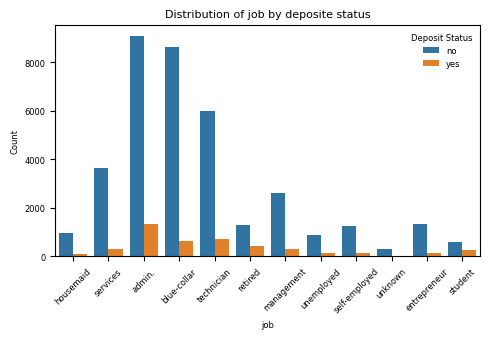

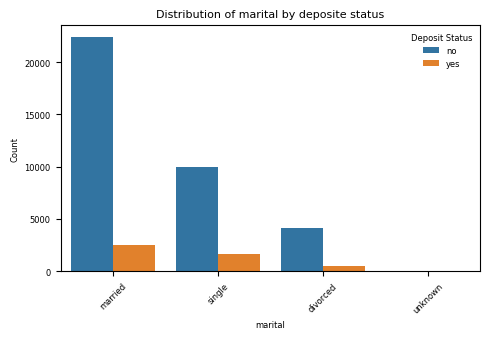

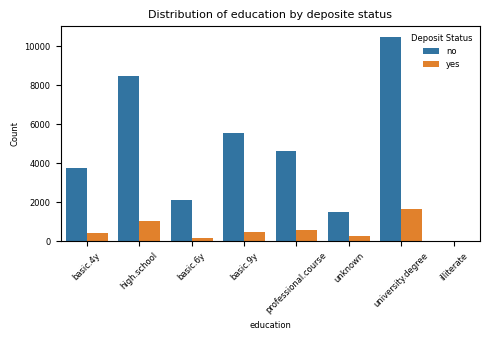

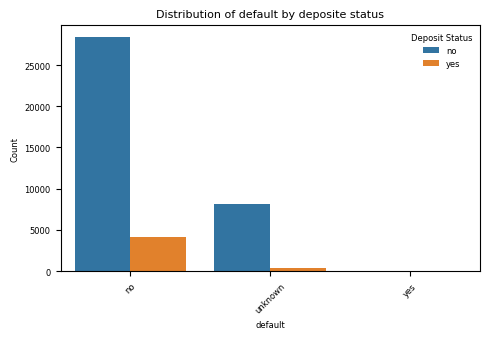

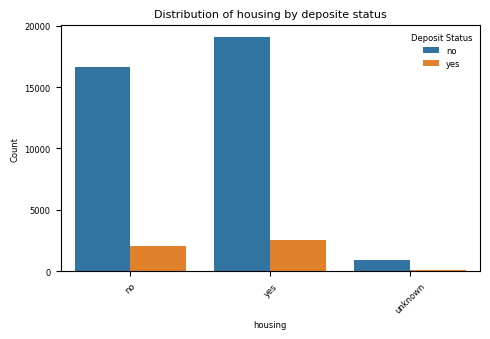

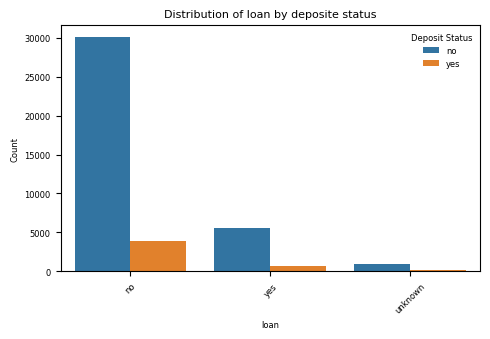

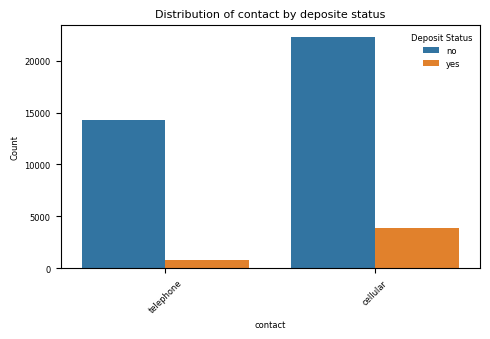

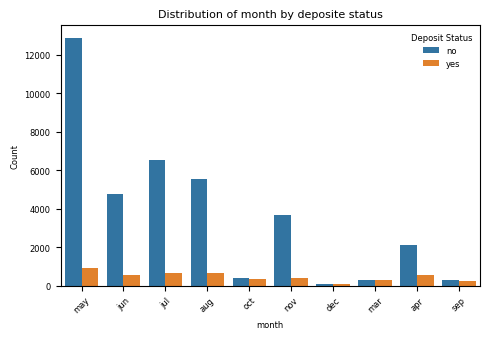

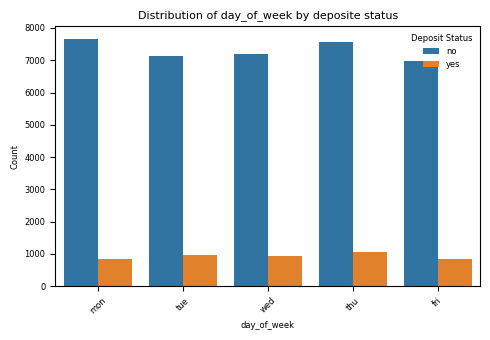

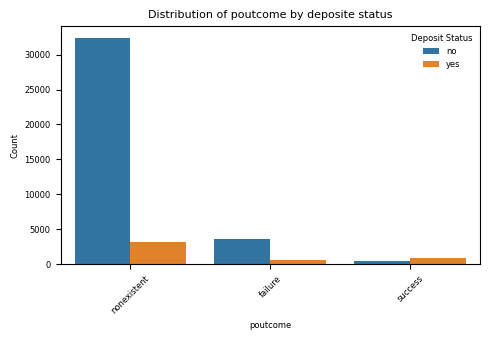

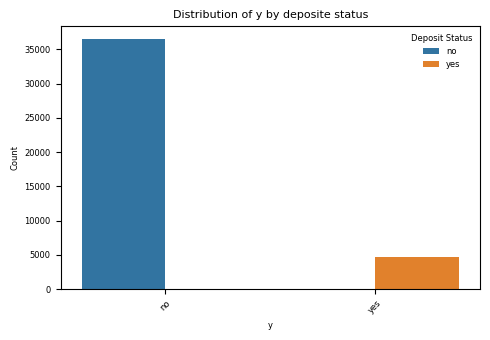

In [294]:
# Plot each categorical variable against 'y'
for col in categorical_columns:
    plt.figure(figsize=(5,3.5))
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Distribution of {col} by deposite status', fontsize = 8)
    plt.xticks(rotation=45, fontsize=6)
    plt.xlabel(col, fontsize=6)
    plt.ylabel('Count', fontsize=6)
    plt.xticks(rotation=45, fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(
        title="Deposit Status",     
        title_fontsize=6,           
        fontsize=6,                 
        loc="best",          
        frameon=False               
    )
    plt.tight_layout()
    plt.savefig(f"{col}_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [296]:
feature_cols = ['job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact']

In [297]:
X = df[feature_cols]
y = df['y']
X.head(5)


,job,marital,education,default,housing,loan,contact
0,housemaid,married,basic.4y,no,no,no,telephone
1,services,married,high.school,unknown,no,no,telephone
2,services,married,high.school,no,yes,no,telephone
3,admin.,married,basic.6y,no,no,no,telephone
4,services,married,high.school,no,no,yes,telephone


In [298]:
y.head(5)

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [299]:
column_trans = make_column_transformer(
(OneHotEncoder(handle_unknown ='ignore'),['job','marital','education','default','contact']),
(OrdinalEncoder(), ['housing','loan']))
column_trans.fit(X)

,transformers,"[('onehotencoder', ...), ('ordinalencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [300]:
LabelEncoder().fit_transform(y)

array([0, 0, 0, ..., 0, 1, 0])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [301]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [302]:
dtc_pipe = Pipeline ([('transformer', column_trans),
                     ('scale', StandardScaler(with_mean=False)),
                     ('model', DecisionTreeClassifier(max_depth=5))
                     ])


In [303]:
dtc = dtc_pipe.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)


In [304]:
dtc_acc = accuracy_score (y_test,dtc_pred)
dtc_pre = precision_score (y_test,dtc_pred, average='macro')
dtc_rec = recall_score (y_test,dtc_pred, average='macro')
dtc_f1 = f1_score (y_test,dtc_pred, average='macro')

print("Accuracy: {:.4f}".format(dtc_acc))
print("Precision: {:.4f}".format(dtc_pre))
print("Recall: {:.4f}".format(dtc_rec))
print("F1-score: {:.4f}".format(dtc_f1))


Accuracy: 0.8863
Precision: 0.4432
Recall: 0.4999
F1-score: 0.4699


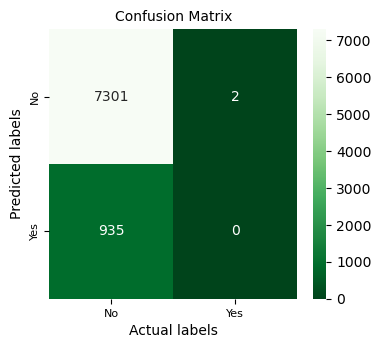

In [305]:
conf_matrix = confusion_matrix(y_test, dtc_pred)
fig,ax= plt.subplots(figsize=(4, 3.5))
sns.heatmap(conf_matrix, annot=True, cmap='Greens_r', fmt='d', ax=ax)
ax.xaxis.set_ticklabels(['No','Yes'],fontsize=8)
ax.yaxis.set_ticklabels(['No','Yes'],fontsize=8)
ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(f"confusion_mat_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [306]:
logr_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model',LogisticRegression())])

In [307]:
logr = logr_pipe.fit(X_train,y_train)
logr_pred = logr.predict(X_test)

In [309]:
y_pred_proba = logr.predict_proba(X_test)
y_probs = y_pred_proba[::,1]
fpr,tpr,threshold = metrics.roc_curve(y_true=y_test, y_score=y_probs, pos_label='yes')
fpr1,tpr1,threshold1 = metrics.roc_curve(y_true=y_test, y_score=y_probs, pos_label='no')

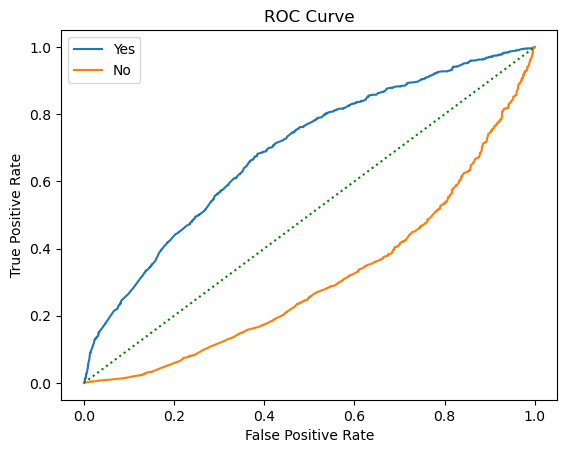

In [310]:
plt.plot(fpr,tpr,label='Yes')
plt.plot(fpr1,tpr1, label='No')
plt.plot([0, 1],[0 ,1], color='green', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig(f"roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [311]:
# Let's see what's the area under the curve auc for our model
auc_area = roc_auc_score(y_true = y_test, y_score = y_probs)
print('Area under the curve is {:.4f}'.format(round(auc_area,3)))

Area under the curve is 0.6890


### Problem 9: Score the Model

What is the accuracy of your model?

In [312]:
logr_acc = accuracy_score (y_test,logr_pred)
logr_pre = precision_score (y_test,logr_pred, average='macro')
logr_rec = recall_score (y_test,logr_pred, average='macro')
logr_f1 = f1_score (y_test,logr_pred, average='macro')

print("Accuracy: {:.4f}".format(logr_acc))
print("Precision: {:.4f}".format(logr_pre))
print("Recall: {:.4f}".format(logr_rec))
print("F1-score: {:.4f}".format(logr_f1))


Accuracy: 0.8865
Precision: 0.4433
Recall: 0.5000
F1-score: 0.4699


/Users/maryamadamzadeh/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [313]:
#Logistic Regression Model
logr1_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model',LogisticRegression())])

start_time_logr1 = time.time()
logr1 = logr1_pipe.fit(X_train,y_train)
logr1_pred = logr1.predict(X_test)
t_time_logr1 = time.time() - start_time_logr1
print(f"Training+prediction time: {t_time_logr1:.4f} seconds")

logr1_train_score = logr1.score(X_train,y_train)
logr1_train_score = logr1.score(X_train,y_train)
print(f'Training Accuracy score :{logr1_train_score:.4f}')
logr1_test_score = logr1.score(X_test,y_test)
print(f'Training Accuracy score :{logr1_test_score:.4f}')

Training+prediction time: 0.1099 seconds
Training Accuracy score :0.8875
Training Accuracy score :0.8865


In [314]:
#Decision Tree Model
dtc1_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model',DecisionTreeClassifier())])

start_time_dtc1 = time.time()
dtc1 = dtc1_pipe.fit(X_train,y_train)
dtc1_pred = dtc1.predict(X_test)
t_time_dtc1 = time.time() - start_time_dtc1
print(f"Training+prediction time: {t_time_dtc1:.4f} seconds")


dtc1_train_score = dtc1.score(X_train,y_train)
dtc1_train_score = dtc1.score(X_train,y_train)
print(f'Training Accuracy score :{dtc1_train_score:.4f}')
dtc1_test_score = dtc1.score(X_test,y_test)
print(f'Training Accuracy score :{dtc1_test_score:.4f}')

Training+prediction time: 0.1507 seconds
Training Accuracy score :0.8915
Training Accuracy score :0.8815


In [ ]:
#KNN Model
knn_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model',KNeighborsClassifier())])

start_time_knn = time.time()
knn = knn_pipe.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
t_time_knn = time.time() - start_time_knn
print(f"Training+prediction time: {t_time_knn:.4f} seconds")

knn_train_score = knn.score(X_train,y_train)
knn_train_score = knn.score(X_train,y_train)
print(f'Training Accuracy score :{knn_train_score:.4f}')
knn_test_score = knn.score(X_test,y_test)
print(f'Training Accuracy score :{knn_test_score:.4f}')

Training+prediction time: 8.1285 seconds


In [245]:
#SVC Model
svm_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model',SVC())])

start_time_svm = time.time()
svm = svm_pipe.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
t_time_svm = time.time() - start_time_svm
print(f"Training+prediction time: {t_time_svm:.4f} seconds")


svm_train_score = svm.score(X_train,y_train)
svm_train_score = svm.score(X_train,y_train)
print(f'Training Accuracy score :{svm_train_score:.4f}')
svm_test_score = svm.score(X_test,y_test)
print(f'Training Accuracy score :{svm_test_score:.4f}')

Training+prediction time: 13.6826 seconds
Training Accuracy score :0.8877
Training Accuracy score :0.8864


In [ ]:
# Display results in DataFrame
pd.DataFrame({"Model":['Logistic Regression','KNN','Decision Tree','SVM'],
             "Train Time(s)":['0.1166','7.8325', '0.1542','13.6826'],
             "Train Accuracy":['0.8875','0.8817','0.8915','0.8877'],
             "Test Accuracy":['0.8865','0.8773','0.8818','0.8864']})


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
#Logistic Regression Model
# Parameter grid
param_grid = [
    {'model__solver': ['lbfgs', 'newton-cg'],
     'model__penalty': ['l2'],
     'model__C': np.logspace(-3, 3, 7)},
    
    {'model__solver': ['liblinear'],
     'model__penalty': ['l1', 'l2'],
     'model__C': np.logspace(-3, 3, 7)},
]

# GridSearchCV setup
gsLR = GridSearchCV(
    estimator=logr1_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

start_time = time.time()
gsLR.fit(X_train, y_train)
train_time = time.time() - start_time

gsLR_pred = gsLR.predict(X_test)


train_score = gsLR.score(X_train, y_train)
test_score = gsLR.score(X_test, y_test)

# Results
print(f"Training+prediction time: {train_time:.4f} seconds")
print(f"Best CV score: {gsLR.best_score_:.4f}")
print(f"Best parameters: {gsLR.best_params_}")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


In [282]:
#KNN
# Parameter grid
param_grid = {"model__n_neighbors": range(1, 18, 2)}

# GridSearchCV setup
gsknn = GridSearchCV(knn_pipe, param_grid, cv=10, scoring='accuracy')

start_time = time.time()
gsknn.fit(X_train, y_train)
train_time = time.time() - start_time

gsknn_pred = gsknn.predict(X_test)

train_score = gsknn.score(X_train, y_train)
test_score = gsknn.score(X_test, y_test)


print(f"Training+prediction time: {train_time:.4f} seconds")
print(f"Best CV score: {gsknn.best_score_:.4f}")
print(f"Best parameters: {gsknn.best_params_}")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Training+prediction time: 239.7218 seconds
Best CV score: 0.8863
Best parameters: {'model__n_neighbors': 15}
Training Accuracy: 0.8870
Test Accuracy: 0.8857


In [ ]:
#Decision Tree Model
# Parameter grid
params = {
    'model__min_samples_leaf': [1, 2, 3],
    'model__max_depth': [1, 2, 3],
    'model__criterion': ['entropy', 'gini']
}

# GridSearchCV setup
gsdtc = GridSearchCV(
    estimator=dtc1_pipe,
    param_grid=params,
    cv=10,
    verbose=2,
    n_jobs=1
)

start_time = time.time()
gsdtc.fit(X_train, y_train)
train_time = time.time() - start_time 

gsdtc_pred = gsdtc.predict(X_test)

train_score = gsdtc.score(X_train, y_train)
test_score = gsdtc.score(X_test, y_test)


print(f"Training+prediction time: {train_time:.4f} seconds")
print(f"Best CV score: {gsdtc.best_score_:.4f}")
print(f"Best parameters: {gsdtc.best_params_}")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


In [287]:
# SVM
#Parameter grid
svm_pipe = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(probability=False))
])


param_grid = {
        'model__kernel': ['rbf', 'linear'],
        'model__C': [0.1, 0.5, 1.0],
        
    }


# GridSearchCV
gsSVC = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1
)


start_time = time.time()
gsSVC.fit(X_train, y_train)
train_time = time.time() - start_time 

svc_pred = gsSVC.predict(X_test)

train_score = gsSVC.score(X_train, y_train)
test_score = gsSVC.score(X_test, y_test)


print(f"Training+prediction time: {train_time:.4f} seconds")
print(f"Best CV score: {gsSVC.best_score_:.4f}")
print(f"Best parameters: {gsSVC.best_params_}")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Training+prediction time: 96.5406 seconds
Best CV score: 0.8876
Best parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
Training Accuracy: 0.8876
Test Accuracy: 0.8865


##### Questions